In [2]:
# Import required packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.io import imread
from skimage.transform import resize
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os

2024-10-31 14:07:41.939265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# Import image data, including flattening the images and converting them to an array
    # (Without masks)
normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
images = []
labels = []
for image in os.listdir(normal_folder_path):
    image_path = os.path.join(normal_folder_path, image)
    i = mpimg.imread(image_path)
    #i = resize(i, (299,299))
    flati = i.flatten()
    images.append(flati)
    labels.append(0)
for image in os.listdir(covid_folder_path):
    image_path = os.path.join(covid_folder_path, image)
    i = mpimg.imread(image_path)
    #i = resize(i, (299,299))
    flati = i.flatten()
    images.append(flati)
    labels.append(1)
X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [3]:
# Import image data, including flattening the images and converting them to an array
    # (With masks)
normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
normal_mask_path = 'COVID-19_Radiography_Dataset/Normal/masks'
covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
covid_mask_path = 'COVID-19_Radiography_Dataset/COVID/masks'
images = []
labels = []
for image in os.listdir(normal_folder_path):
    image_path = os.path.join(normal_folder_path, image)
    mask_path = os.path.join(normal_mask_path, image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(0)
for image in os.listdir(covid_folder_path):
    image_path = os.path.join(covid_folder_path, image)
    mask_path = os.path.join(covid_mask_path,image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(1)
X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [4]:
# Split the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Try to train a logistic regression model (didn't work)
model = LogisticRegression(max_iter=10, solver='lbfgs')
model.fit(X_train, y_train)

/Users/jacobpennington/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
# Convert to tensors for PyTorch training
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

/var/folders/s5/mpkn88sn4gb3bl9vdnssxvw40000gn/T/ipykernel_50325/929538957.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
/var/folders/s5/mpkn88sn4gb3bl9vdnssxvw40000gn/T/ipykernel_50325/929538957.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
/var/folders/s5/mpkn88sn4gb3bl9vdnssxvw40000gn/T/ipykernel_50325/929538957.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dt

In [7]:
# Define a direct MLP model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 5000),
            nn.ReLU(),
            nn.Linear(5000, 100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
# Train the model (only 1 epoch and it took 30 minutes yikes)
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

loss_function = nn.BCELoss()
model = NeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
train_MSE = []

for epoch in range(num_epochs):
    counter = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        counter += 1
        print(counter)
        train_MSE.append(loss.item())
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


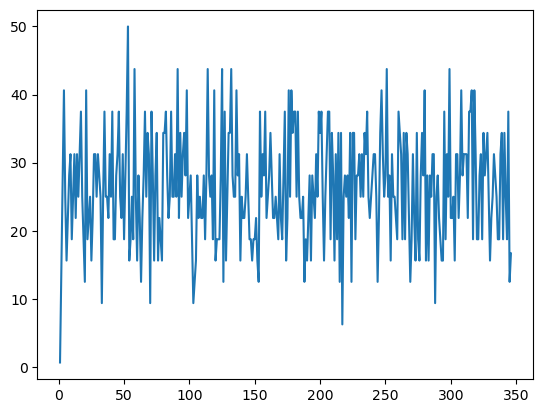

In [15]:
# Graph the error on each batch in the epoch I trained
len(train_MSE)
plt.plot(range(1, counter+1),train_MSE)

In [16]:
# Test the MLP model on the test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

def test_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Forward pass: compute predictions
            outputs = model(inputs)
            
            # Since our output is a single probability (binary classification), 
            # apply threshold to classify
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            
            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Example usage:
# Assuming `model` is your trained model and `test_dataloader` is your test data loader
test_model(model, test_dataloader)

Test Accuracy: 74.62%


In [ ]:
# This was just so I can remember these commands for later, you can ignore them
np.set_printoptions(threshold=np.inf)
np.set_printoptions()